In [1]:
# Imports
from scipy.io import loadmat
import json
import numpy as np
import random
from metric_learn.lmnn import LMNN
from metric_learn.covariance import Covariance
from metric_learn.mlkr import MLKR
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
random.seed(9999999)

In [2]:
# Access raw data from files
train_idxs = loadmat('PR_data/cuhk03_new_protocol_config_labeled.mat')['train_idx'].flatten()-1
query_idxs = loadmat('PR_data/cuhk03_new_protocol_config_labeled.mat')['query_idx'].flatten()-1
gallery_idxs = loadmat('PR_data/cuhk03_new_protocol_config_labeled.mat')['gallery_idx'].flatten()-1
labels = loadmat('PR_data/cuhk03_new_protocol_config_labeled.mat')['labels'].flatten()
camId = loadmat('PR_data/cuhk03_new_protocol_config_labeled.mat')['camId'].flatten()
filelist = loadmat('PR_data/cuhk03_new_protocol_config_labeled.mat')['filelist'].flatten()
with open('PR_data/feature_data.json','r') as f:
    features = json.load(f)
features = np.array(features) # rows: pictures, columns: features (one row contains one image)

In [3]:
# Create the usable data sets from the given indices
train_feat = features[train_idxs,:]
train_labels = labels[train_idxs]
train_camId = camId[train_idxs]
query_feat = features[query_idxs,:]
query_labels = labels[query_idxs]
query_camId = camId[query_idxs]
gallery_feat = features[gallery_idxs,:]
gallery_labels = labels[gallery_idxs]
gallery_camId = camId[gallery_idxs]

In [4]:
# Create a validation set
unique_id_train = np.unique(train_labels) #find all unique training IDs
unique_id_val = unique_id_train[np.array(random.sample(range(unique_id_train.shape[0]),100))] # pick 100 random unique training IDs, random.sample does not work on numpy array 
bool_idx_val = np.isin(train_labels, unique_id_val)
bool_idx_train_noval = np.isin(train_labels, unique_id_val, invert=True)

train_noval_feat = train_feat[bool_idx_train_noval,:]
train_noval_labels = train_labels[bool_idx_train_noval]
train_noval_camId = train_camId[bool_idx_train_noval]
train_noval_filelist_idxs = train_idxs[bool_idx_train_noval]

val_feat = train_feat[bool_idx_val,:]
val_labels = train_labels[bool_idx_val]
val_camId = train_camId[bool_idx_val]
val_filelist_idxs = train_idxs[bool_idx_val]

In [5]:
# Create gallery and query set for validation
val_label_cam_pair = np.append(val_labels.reshape((1,val_labels.shape[0])),val_camId.reshape((1,val_camId.shape[0])),axis=0)
val_pair_unique, val_pair_unique_indxs = np.unique(val_label_cam_pair, axis=1, return_index=True)

val_query_feat = val_feat[val_pair_unique_indxs,:]
val_query_labels = val_labels[val_pair_unique_indxs]
val_query_camId = val_camId[val_pair_unique_indxs]

val_gallery_feat = np.delete(val_feat, val_pair_unique_indxs, axis = 0)
val_gallery_labels = np.delete(val_labels, val_pair_unique_indxs)
val_gallery_camId = np.delete(val_camId, val_pair_unique_indxs)

idxs_delete = []
for i in range(val_query_labels.shape[0]):
    g_camId = val_gallery_camId[val_gallery_labels==val_query_labels[i]]
    if (val_query_camId[i]==1 and (2 not in g_camId)) or (val_query_camId[i]==2 and (1 not in g_camId)):
        val_gallery_feat = np.append(val_gallery_feat, val_query_feat[[i],:],axis=0)
        val_gallery_labels = np.append(val_gallery_labels, val_query_labels[i])
        val_gallery_camId = np.append(val_gallery_camId, val_query_camId[i])
        idxs_delete.append(i)

val_query_feat = np.delete(val_query_feat, idxs_delete, axis = 0)
val_query_labels = np.delete(val_query_labels, idxs_delete)
val_query_camId = np.delete(val_query_camId, idxs_delete)

In [6]:
def kNN (t_query_feat, t_gallery_feat):
    # k nearest neighbours implementation
    k = 10
    top_k_accuracies_rank = np.zeros((query_labels.shape[0],k))
    top_k_accuracies_classical = np.zeros((query_labels.shape[0],k))
    top_k_accuracies_recall = np.zeros((query_labels.shape[0],k))

    nbrs = NearestNeighbors(n_neighbors=20).fit(t_gallery_feat)
    distances, indices = nbrs.kneighbors(t_query_feat)
    # Indices contains indices of the closes gallery pictures to each query image

    # Select the images where camId and label not the same as of the query image
    # Take top k of them

    for i in range (0, query_labels.shape[0], 1):
        selected_indices = np.logical_not(np.logical_and(gallery_camId[indices[i, :]] == query_camId[i], gallery_labels[indices[i,:]] == query_labels[i]))
        number_of_removed = np.sum(np.logical_and(gallery_camId == query_camId[i], gallery_labels == query_labels[i]))
        removed_indices = indices [i, selected_indices]
        is_same_label = (query_labels[i] == gallery_labels[removed_indices])

        for j in range (0, k, 1):
            top_k_accuracies_rank[i,j] = np.sum(is_same_label[:(j+1)]) != 0
            top_k_accuracies_classical[i,j]=np.sum(is_same_label[:(j+1)])/(j+1)
            top_k_accuracies_recall[i,j] = np.sum(is_same_label[:(j+1)])/(np.sum(gallery_labels==query_labels[i])-number_of_removed)

    print (top_k_accuracies_rank[:, 0].mean())
    print (top_k_accuracies_classical[:, 0].mean())
    print (top_k_accuracies_recall[:, 0].mean())
    print (top_k_accuracies_rank[:, 0].mean())
    print (top_k_accuracies_rank[:, 4].mean())
    print (top_k_accuracies_rank[:, 9].mean())
    
    average_precisions = np.zeros((query_labels.shape))
    for j in range (0, query_labels.shape[0], 1):
        recall = top_k_accuracies_recall[j, :]
        precision = top_k_accuracies_classical[j, :]
        index = (recall).argsort()[::-1] # argsort returns the indices that would sort an array (in this case the vector recall)
        recall = recall[index]
        precision = precision[index]
        recall_range = np.arange(0, 1.1, 0.1)
        precision_range = np.zeros((recall_range.shape))
        for i in range (0, recall_range.shape[0], 1):    
            if (precision[recall>=recall_range[i]].size != 0):
                precision_range[i] = np.max(precision[recall>=recall_range[i]])
            else:     
                precision_range[i] = 0
        average_precisions[j] = np.mean(precision_range)
    
    print ("Mean average precision:", average_precisions.mean()) 
    return

In [7]:
def kNN_val (t_query_feat, t_gallery_feat):
    # k nearest neighbours implementation
    k = 10
    top_k_accuracies_rank = np.zeros((val_query_labels.shape[0],k))
    top_k_accuracies_classical = np.zeros((val_query_labels.shape[0],k))
    top_k_accuracies_recall = np.zeros((val_query_labels.shape[0],k))

    nbrs = NearestNeighbors(n_neighbors=20).fit(t_gallery_feat)
    distances, indices = nbrs.kneighbors(t_query_feat)
    # Indices contains indices of the closes gallery pictures to each query image

    # Select the images where camId and label not the same as of the query image
    # Take top k of them

    for i in range (0, val_query_labels.shape[0], 1):
        selected_indices = np.logical_not(np.logical_and(val_gallery_camId[indices[i, :]] == val_query_camId[i], val_gallery_labels[indices[i,:]] == val_query_labels[i]))
        number_of_removed = np.sum(np.logical_and(val_gallery_camId == val_query_camId[i], val_gallery_labels == val_query_labels[i]))
        removed_indices = indices [i, selected_indices]
        is_same_label = (val_query_labels[i] == val_gallery_labels[removed_indices])

        for j in range (0, k, 1):
            top_k_accuracies_rank[i,j] = np.sum(is_same_label[:(j+1)]) != 0
            top_k_accuracies_classical[i,j]=np.sum(is_same_label[:(j+1)])/(j+1)
            top_k_accuracies_recall[i,j] = np.sum(is_same_label[:(j+1)])/(np.sum(val_gallery_labels==val_query_labels[i])-number_of_removed)

    print (top_k_accuracies_rank[:, 0].mean())
    print (top_k_accuracies_classical[:, 0].mean())
    print (top_k_accuracies_recall[:, 0].mean())
    print (top_k_accuracies_rank[:, 0].mean())
    print (top_k_accuracies_rank[:, 4].mean())
    print (top_k_accuracies_rank[:, 9].mean())

    average_precisions = np.zeros((val_query_labels.shape))
    for j in range (0, val_query_labels.shape[0], 1):
        recall = top_k_accuracies_recall[j, :]
        precision = top_k_accuracies_classical[j, :]
        index = (recall).argsort()[::-1] # argsort returns the indices that would sort an array (in this case the vector recall)
        recall = recall[index]
        precision = precision[index]
        recall_range = np.arange(0, 1.1, 0.1)
        precision_range = np.zeros((recall_range.shape))
        for i in range (0, recall_range.shape[0], 1):    
            if (precision[recall>=recall_range[i]].size != 0):
                precision_range[i] = np.max(precision[recall>=recall_range[i]])
            else:     
                precision_range[i] = 0
        average_precisions[j] = np.mean(precision_range)
    
    print ("Mean average precision:", average_precisions.mean())
    return

In [8]:
# Could be deleted, it is not necessary to duplicate it

# k nearest neighbours implementation

k = 10
top_k_accuracies_rank = np.zeros((query_labels.shape[0],k))
top_k_accuracies_classical = np.zeros((query_labels.shape[0],k))
top_k_accuracies_recall = np.zeros((query_labels.shape[0],k))

nbrs = NearestNeighbors(n_neighbors=20).fit(gallery_feat)
distances, indices = nbrs.kneighbors(query_feat)

# Indices contains indices of the closes gallery pictures to each query image

# Select the images where camId and label not the same as of the query image
# Take top k of them

for i in range (0, query_labels.shape[0], 1):
    selected_indices = np.logical_not(np.logical_and(gallery_camId[indices[i, :]] == query_camId[i], gallery_labels[indices[i,:]] == query_labels[i]))
    number_of_removed = np.sum(np.logical_and(gallery_camId == query_camId[i], gallery_labels == query_labels[i]))
    removed_indices = indices [i, selected_indices]
    is_same_label = (query_labels[i] == gallery_labels[removed_indices])
    
    for j in range (0, k, 1):
        top_k_accuracies_rank[i,j] = np.sum(is_same_label[:(j+1)]) != 0
        top_k_accuracies_classical[i,j]=np.sum(is_same_label[:(j+1)])/(j+1)
        top_k_accuracies_recall[i,j] = np.sum(is_same_label[:(j+1)])/(np.sum(gallery_labels==query_labels[i])-number_of_removed)

print (top_k_accuracies_rank[:, 0].mean())
print (top_k_accuracies_classical[:, 0].mean())
print (top_k_accuracies_recall[:, 0].mean())
print (top_k_accuracies_rank[:, 0].mean())
print (top_k_accuracies_rank[:, 4].mean())
print (top_k_accuracies_rank[:, 9].mean())

0.47
0.47
0.12738095238095237
0.47
0.6685714285714286
0.7492857142857143


[0.25 0.5  0.5  0.5  0.5  0.5  0.5  0.75 1.   1.  ]
[1.         1.         0.66666667 0.5        0.4        0.33333333
 0.28571429 0.375      0.44444444 0.4       ]


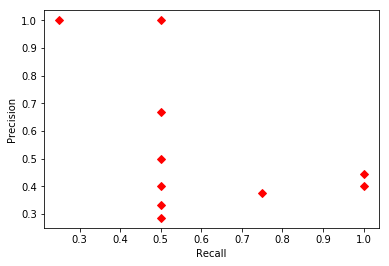

[1.   1.   0.75 0.5  0.5  0.5  0.5  0.5  0.5  0.25]
[0.4        0.44444444 0.44444444 0.44444444 0.44444444 0.44444444
 0.5        0.66666667 1.         1.        ]


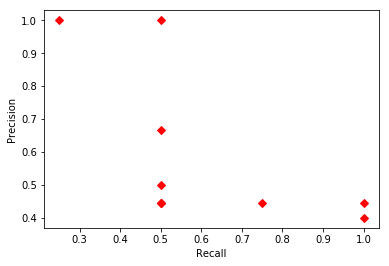

[1.         1.         1.         1.         1.         1.
 0.44444444 0.44444444 0.44444444 0.44444444 0.44444444]


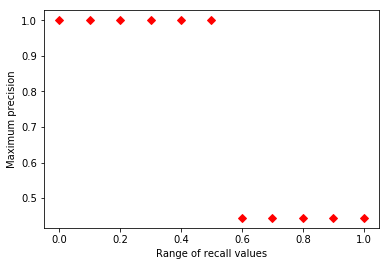

0.7474747474747475


In [9]:
# Average precision calculation demonstration
# Try index 1100, that is representative

recall = top_k_accuracies_recall[1100, :]
precision = top_k_accuracies_classical[1100, :]
print (recall)
print (precision)

# Just plot the recall, precision values
plt.figure()
plt.plot(recall, precision, 'rD')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# Flat out the variation (not used in any calculations!)
index = (recall).argsort()[::-1] # argsort returns the indices that would sort an array (in this case the vector recall)
recall = recall[index]
precision = precision[index]
for i in range (0, recall.shape[0], 1):
    precision[i] = np.max(precision[:(i+1)])
print (recall)
print (precision)

plt.figure()
plt.plot(recall, precision, 'rD')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# Calculate the mean average precision values
recall = top_k_accuracies_recall[1100, :]
precision = top_k_accuracies_classical[1100, :]

index = (recall).argsort()[::-1] # argsort returns the indices that would sort an array (in this case the vector recall)
recall = recall[index]
precision = precision[index]
recall_range = np.arange(0, 1.1, 0.1)
precision_range = np.zeros((recall_range.shape))
for i in range (0, recall_range.shape[0], 1):
    if (precision[recall>=recall_range[i]].size != 0):
        precision_range[i] = np.max(precision[recall>=recall_range[i]])
    else:     
        precision_range[i] = 0
print (precision_range)

plt.figure()
plt.plot(recall_range, precision_range, 'rD')
plt.xlabel('Range of recall values')
plt.ylabel('Maximum precision')
plt.show()

ap = np.mean(precision_range)
print (ap)

In [10]:
count = 0
average_precisions = np.zeros((query_labels.shape))
for j in range (0, query_labels.shape[0], 1):
    recall = top_k_accuracies_recall[j, :]
    precision = top_k_accuracies_classical[j, :]
    index = (recall).argsort()[::-1] # argsort returns the indices that would sort an array (in this case the vector recall)
    recall = recall[index]
    precision = precision[index]
    recall_range = np.arange(0, 1.1, 0.1)
    precision_range = np.zeros((recall_range.shape))
    for i in range (0, recall_range.shape[0], 1):    
        if (precision[recall>=recall_range[i]].size != 0):
            precision_range[i] = np.max(precision[recall>=recall_range[i]])
        else:     
            precision_range[i] = 0
    average_precisions[j] = np.mean(precision_range)
print (average_precisions, average_precisions.shape)
print (average_precisions.mean())

[0.         0.03636364 1.         ... 0.5        0.94545455 0.85454545] (1400,)
0.4353663677592249


In [11]:
# Kmeans clustering

# very long 
#k_means_predictions = np.zeros((query_labels.shape[0]))
#for i in range (0, query_labels.shape[0], 1):
#    gallery_feat_removed, gallery_labels_removed = get_removed_gallery (i)
#    kmeans = KMeans(n_clusters=((np.unique(gallery_labels_removed)).shape[0]), n_init=1, max_iter=10, random_state=0, precompute_distances= True).fit(gallery_feat_removed)
#    k_means_predictions[i] = kmeans.predict(query_feat[i:(i+1), :])
#    print (i)
#    print (k_means_predictions[i], query_labels[i])
#accuracy = (np.sum(k_means_predictions == query_labels))/(query_labels.shape[0])
#print (accuracy)
#print(k_means_predictions, k_means_predictions.shape, query_labels, query_labels.shape)

import sklearn.utils.linear_assignment_ as la
from sklearn.metrics import accuracy_score
from sklearn.metrics.cluster import normalized_mutual_info_score

def best_map(l1, l2):
    """
    Permute labels of l2 to match l1 as much as possible
    """
    if len(l1) != len(l2):
        print("L1.shape must == L2.shape")
        exit(0)

    label1 = np.unique(l1)
    n_class1 = len(label1)

    label2 = np.unique(l2)
    n_class2 = len(label2)

    n_class = max(n_class1, n_class2)
    G = np.zeros((n_class, n_class))

    for i in range(0, n_class1):
        for j in range(0, n_class2):
            ss = l1 == label1[i]
            tt = l2 == label2[j]
            G[i, j] = np.count_nonzero(ss & tt)

    A = la.linear_assignment(-G)

    new_l2 = np.zeros(l2.shape)
    for i in range(0, n_class2):
        new_l2[l2 == label2[A[i][1]]] = label1[A[i][0]]
    return new_l2.astype(int)

k_means_predictions = np.zeros((query_labels.shape[0]))

kmeans = KMeans (n_clusters=np.unique(gallery_labels).shape[0], n_init =1, max_iter = 10, random_state = 0, precompute_distances=True).fit(gallery_feat)

labels = best_map(gallery_labels, kmeans.labels_)

#for i in range (0, query_labels.shape[0], 1):
#    k_means_predictions[i] = kmeans.predict(query_feat[i:(i+1), :])
#    print (i)
#    print (k_means_predictions[i], query_labels[i])
#accuracy = (np.sum(k_means_predictions == labels))/(query_labels.shape[0])
#print (accuracy)
#print(k_means_predictions, k_means_predictions.shape, query_labels, query_labels.shape)

In [12]:
print (labels, gallery_labels, kmeans.labels_)
print (labels.shape, gallery_labels.shape, kmeans.labels_.shape)

[1426   51   51 ... 1463 1463 1463] [   3    3    3 ... 1463 1463 1463] [582  63  63 ... 178 178 178]
(5328,) (5328,) (5328,)


In [13]:
np.sum(labels==gallery_labels)

3604

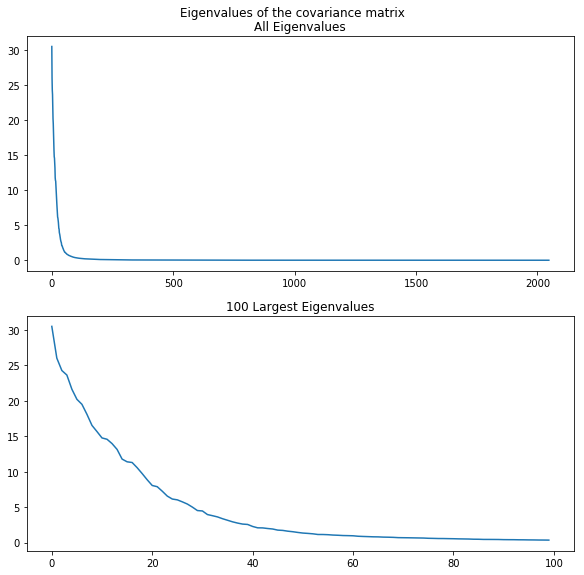

Percentage of total data variance captured: 0.9903464772680631


In [14]:
#DO PCA
pca_train_noval =PCA()
pca_train_noval.fit(train_noval_feat)
pca_train_noval_eigvals = pca_train_noval.explained_variance_

x = np.arange(0, pca_train_noval_eigvals.shape[0])
fig, axs = plt.subplots(2, 1, constrained_layout = True, figsize = (8, 8))
axs[0].plot(x, pca_train_noval_eigvals, '-')
axs[0].set_title('All Eigenvalues')

fig.suptitle('Eigenvalues of the covariance matrix')
axs[1].plot(x[:100], pca_train_noval_eigvals[:100], '-')
axs[1].set_title('100 Largest Eigenvalues')
plt.show()

print("Percentage of total data variance captured:", 
      (np.sum(pca_train_noval_eigvals[:500]))/(np.sum(pca_train_noval_eigvals[:500])+np.sum(pca_train_noval_eigvals[500:])))

In [15]:
pca = PCA(n_components=500)
#train_noval_feat_reduced = pca.fit_transform(train_noval_feat)
train_feat_reduced = pca.fit_transform(train_feat)
query_feat_reduced = pca.transform(query_feat)
gallery_feat_reduced = pca.transform(gallery_feat)

In [16]:
# Apply all of our models

# Apply baseline kNN model again
kNN(query_feat, gallery_feat)
kNN_val(val_query_feat, val_gallery_feat)

0.47
0.47
0.12738095238095237
0.47
0.6685714285714286
0.7492857142857143
Mean average precision: 0.4353663677592249
1.0
1.0
0.2899497487437186
1.0
1.0
1.0
Mean average precision: 1.0


In [17]:
# Covariance Mahalanobis model

Cov_Model = Covariance().fit(train_feat, train_labels)
query_feat_Cov = Cov_Model.transform(query_feat)
gallery_feat_Cov = Cov_Model.transform(gallery_feat)
kNN(query_feat_Cov, gallery_feat_Cov)

Cov_Model_val = Covariance().fit(train_noval_feat, train_noval_labels)
val_query_feat_Cov = Cov_Model_val.transform(val_query_feat)
val_gallery_feat_Cov = Cov_Model_val.transform(val_gallery_feat)
kNN_val(val_query_feat_Cov, val_gallery_feat_Cov)

Cov_Model_red = Covariance().fit(train_feat_reduced, train_labels)
query_feat_Cov_red = Cov_Model_red.transform(query_feat_reduced)
gallery_feat_Cov_red = Cov_Model_red.transform(gallery_feat_reduced)
kNN(query_feat_Cov_red, gallery_feat_Cov_red)

0.3092857142857143
0.3092857142857143
0.08291666666666667
0.3092857142857143
0.455
0.5014285714285714
Mean average precision: 0.2337029220779221
0.9949748743718593
0.9949748743718593
0.2849246231155779
0.9949748743718593
0.9949748743718593
1.0
Mean average precision: 0.979396984924623
0.37857142857142856
0.37857142857142856
0.10238095238095236
0.37857142857142856
0.5971428571428572
0.67
Mean average precision: 0.33971088435374147


In [18]:
LargeMarg_Model = LMNN(verbose=True).fit(train_feat,train_labels)
query_feat_LMNN = LargeMarg_Model.transform(query_feat)
gallery_feat_LMNN = LargeMarg_Model.transform(gallery_feat)

kNN(query_feat_LMNN, gallery_feat_LMNN)

#val_query_feat_M = M.transform(val_query_feat)
#val_gallery_feat_M = M.transform(val_gallery_feat)

#feat_dict_val["LMNN"]=(val_query_feat_M,val_gallery_feat_M)

LargeMarg_Model_red = LMNN(verbose=True).fit(train_feat_reduced,train_labels)
query_feat_LMNN_red = LargeMarg_Model_red.transform(query_feat_reduced)
gallery_feat_LMNN_red = LargeMarg_Model_red.transform(gallery_feat_reduced)

kNN(query_feat_LMNN_red, gallery_feat_LMNN_red)

/Users/karolyhorvath/anaconda3/lib/python3.6/site-packages/metric_learn/lmnn.py:62: UserWarning: use_pca does nothing for the python_LMNN implementation
  warnings.warn('use_pca does nothing for the python_LMNN implementation')


2 765604.8409514618 -2816.713554516202 28 1.0099999999999999e-07
3 762768.9081833549 -2835.9327681069262 27 1.0201e-07
4 759915.330559735 -2853.577623619931 27 1.030301e-07
5 757042.9118664912 -2872.4186932437588 26 1.0406040099999999e-07
6 754152.8838508244 -2890.0280156667577 25 1.0510100500999999e-07
7 751245.2307615683 -2907.6530892561423 24 1.0615201506009999e-07
8 748319.1061694798 -2926.124592088512 24 1.0721353521070098e-07
9 745375.006323377 -2944.099846102763 22 1.08285670562808e-07
10 742414.2419775834 -2960.7643457936356 21 1.0936852726843608e-07
11 739435.3387439452 -2978.9032336381497 21 1.1046221254112044e-07
12 736437.786481913 -2997.552262032288 19 1.1156683466653164e-07
13 733422.8023871656 -3014.984094747342 19 1.1268250301319696e-07
14 730388.6561803278 -3034.146206837846 19 1.1380932804332893e-07
15 727335.3770936304 -3053.279086697381 19 1.1494742132376222e-07
16 724262.9990907772 -3072.378002853133 19 1.1609689553699984e-07
17 721171.7668415101 -3091.232249267166

128 336019.60411245143 -2195.833083941019 0 3.538461465303104e-07
129 333908.6814979336 -2110.9226145178545 0 3.573846079956135e-07
130 331885.6665204178 -2023.0149775157915 0 3.6095845407556966e-07
131 329953.6294952234 -1932.0370251943823 0 3.645680386163254e-07
132 328115.7154847261 -1837.9140104972757 0 3.6821371900248867e-07
133 326375.14593110955 -1740.569553616573 0 3.7189585619251353e-07
134 324735.2203232434 -1639.925607866142 0 3.7561481475443865e-07
135 323199.3178983738 -1535.9024248695932 0 3.7937096290198303e-07
136 321770.89937935624 -1428.4185190175776 0 3.8316467253100284e-07
137 320453.5087481453 -1317.390631210932 0 3.8699631925631286e-07
138 319250.7750562849 -1202.7336918603978 0 3.9086628244887597e-07
139 318166.414273167 -1084.3607831178815 0 3.947749452733647e-07
140 317204.2311728171 -962.1831003499101 0 3.987226947260984e-07
141 316368.12126000324 -836.109912813874 0 4.027099216733594e-07
142 315662.07273647364 -706.0485235296073 0 4.0673702089009297e-07
143 3

/Users/karolyhorvath/anaconda3/lib/python3.6/site-packages/metric_learn/lmnn.py:62: UserWarning: use_pca does nothing for the python_LMNN implementation
  warnings.warn('use_pca does nothing for the python_LMNN implementation')


2 699962.9745553596 -2792.8715002026875 28 1.0099999999999999e-07
3 697151.0063839298 -2811.9681714298204 28 1.0201e-07
4 694320.3919502769 -2830.6144336528378 27 1.030301e-07
5 691471.7593715911 -2848.6325786857633 27 1.0406040099999999e-07
6 688604.6513120481 -2867.1080595430685 25 1.0510100500999999e-07
7 685720.9323860701 -2883.7189259779407 24 1.0615201506009999e-07
8 682819.2572510896 -2901.6751349805854 24 1.0721353521070098e-07
9 679898.8671415505 -2920.390109539032 23 1.08285670562808e-07
10 676961.3018396022 -2937.5653019483434 22 1.0936852726843608e-07
11 674005.5854686464 -2955.716370955808 21 1.1046221254112044e-07
12 671032.5535732358 -2973.0318954106187 20 1.1156683466653164e-07
13 668041.0153605589 -2991.538212676882 19 1.1268250301319696e-07
14 665031.8439536511 -3009.171406907728 19 1.1380932804332893e-07
15 662003.6683631886 -3028.175590462517 19 1.1494742132376222e-07
16 658956.521406699 -3047.1469564896543 19 1.1609689553699984e-07
17 655890.4407093583 -3066.080697

128 273208.74857886153 -2196.389022929012 0 3.538461465303104e-07
129 271096.12053912884 -2112.628039732692 0 3.573846079956135e-07
130 269070.2161623801 -2025.9043767487165 0 3.6095845407556966e-07
131 267134.0704691072 -1936.1456932729343 0 3.645680386163254e-07
132 265290.79240246257 -1843.2780666446197 0 3.6821371900248867e-07
133 263543.566443292 -1747.2259591705515 0 3.7189585619251353e-07
134 261895.65425892183 -1647.9121843701869 0 3.7561481475443865e-07
135 260350.39638639137 -1545.257872530463 0 3.7937096290198303e-07
136 258911.21395083613 -1439.182435555238 0 3.8316467253100284e-07
137 257581.6104197413 -1329.603531094821 0 3.8699631925631286e-07
138 256365.17339380074 -1216.4370259405696 0 3.9086628244887597e-07
139 255265.57643512942 -1099.5969586713181 0 3.947749452733647e-07
140 254286.58093359432 -978.9955015351006 0 3.987226947260984e-07
141 253432.0380120438 -854.5429215505137 0 4.027099216733594e-07
142 252705.8904712314 -726.1475408124097 0 4.0673702089009297e-07
1

In [19]:
MLKR_Model = MLKR(verbose=True).fit(train_feat,train_labels)
query_feat_MLKR = MLKR_Model.transform(query_feat)
gallery_feat_MLKR = MLKR_Model.transform(gallery_feat)

kNN(query_feat_MLKR, gallery_feat_MLKR)

MLKR_Model_red = MLKR(verbose=True).fit(train_feat_reduced,train_labels)
query_feat_MLKR_red = MLKR_Model_red.transform(query_feat_reduced)
gallery_feat_MLKR_red = MLKR_Model_red.transform(gallery_feat_reduced)

kNN(query_feat_MLKR_red, gallery_feat_MLKR_red)

[MLKR]
[MLKR]  Iteration      Objective Value    Time(s)
[MLKR] ------------------------------------------
[MLKR]          0         2.116000e+03      28.40
[MLKR] Training took    30.65s.
0.47
0.47
0.12738095238095237
0.47
0.6685714285714286
0.7492857142857143
Mean average precision: 0.4353663677592249
[MLKR]
[MLKR]  Iteration      Objective Value    Time(s)
[MLKR] ------------------------------------------
[MLKR]          0         2.116000e+03       9.61
[MLKR] Training took     9.84s.
0.4685714285714286
0.4685714285714286
0.1270238095238095
0.4685714285714286
0.6714285714285714
0.7492857142857143
Mean average precision: 0.4357974902082045


In [20]:
#M_reduced = LMNN(verbose=True).fit(train_noval_feat_reduced,train_noval_labels)

#val_query_feat_reduced = pca.transform(val_query_feat)
#val_gallery_feat_reduced = pca.transform(val_gallery_feat)
#print(val_query_feat_reduced.shape, val_gallery_feat_reduced.shape)

#val_query_feat_M_reduced = M_reduced.transform(val_query_feat_reduced)
#val_gallery_feat_M_reduced = M_reduced.transform(val_gallery_feat_reduced)

#feat_dict_val["LMNN reduced"]=(val_query_feat_M_reduced,val_gallery_feat_M_reduced)